# Movilidad y características de comunas

(Muchas gracias a Carlos Alvarado y Jorge Fantuzzi. Todo el código y datos para reproducir este análisis se encuentra en https://github.com/cdagnino/mobility_and_comuna)

Uno de los factores más estudiados en la velocidad de transmisión de las epidemias es la movilidad de la población. Las cuarentenas voluntarias u obligatorias justamente apuntan a disminuir la tasa de contagio mediante una disminución del movimiento de las personas. Una pregunta que surge naturalmente es si el efecto de estas cuarentenas depende de las características de las comunas. Por ejemplo, ["Efectividad de las cuarentenas y características de las comunas"](http://contrafactual.cl/2020/05/31/efectividad-de-las-cuarentenas-y-caracteristicas-de-las-comunas/) analiza el efecto del hacinamiento, la densidad y el trabajo informal en la efectividad de las comunas. En EEUU, Jung et alii (2020)[1] encuentran que hay una relación en forma de U entre el nivel de pobreza de los condados y la velocidad de contagio. Encuentran que esto puede ser explicado por dos hechos:

+ i) En la fase inicial, las infecciones están más concentradas en condados de mayores ingresos
+ ii) La disminución de movilidad fue menor en los condados más pobres

En esta nota, analizaré el efecto del nivel de pobreza de las comunas de Chile en la reducción de la movilidad. Encuentro que un porcentaje adicional de aumento en pobreza está asociado a una disminución de 2.3% del efecto de las cuarentenas. Por ejemplo, la cuaretena disminuye, en promedio, un 25% la movilidad de una comuna con 0% de pobreza, 15% de disminuición para una comuna con un 5% de pobreza y 0% de efecto para una comuna cercana a los 15% de pobreza.


[1] Juergen Jung, James Manley and Vinish Shrestha: "Coronavirus infections and deaths by poverty status: Time trends and patterns"

In [20]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
matplotlib.style.use("fivethirtyeight")

## Load Data

In [21]:
prod_33 = "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto33/"
mobility = pd.read_csv(prod_33 + "IndiceDeMovilidad.csv")
mobility["Fecha"] = pd.to_datetime(mobility.Fecha, format="%Y-%m-%d")
mobility['lagged_Fecha'] = mobility['Fecha'] - pd.Timedelta("8d")

### Data fechas cuarentena

In [23]:
path_cuarentena = "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto29/Cuarentenas-Totales.csv"

df_cuarentena = pd.read_csv(path_cuarentena)

df_cuarentena["fecha_inicio"] = pd.to_datetime(df_cuarentena['Fecha de Inicio'], format="%Y-%m-%d %H:%M:%S").dt.date
df_cuarentena["fecha_termino"] = pd.to_datetime(df_cuarentena['Fecha de Término'], format="%Y-%m-%d %H:%M:%S").dt.date

df_list = []
for i, row in df_cuarentena.iterrows():
    comuna = row['Código CUT Comuna']
    fecha_ini = row['fecha_inicio']
    fecha_end = row['fecha_termino']
    fechas = pd.date_range(start=fecha_ini, end=fecha_end)
    df_aux = pd.DataFrame(fechas)
    df_aux['Codigo comuna'] = comuna
    df_list.append(df_aux)
df_fechas = pd.concat(df_list)
df_fechas.drop_duplicates(inplace=True)
df_fechas.rename(columns={0: 'Fecha'}, inplace=True)
df_fechas['cuarentena'] = 1

mobility = mobility.merge(df_fechas, how='left', on=['Codigo comuna', 'Fecha'])
mobility['cuarentena'] = mobility['cuarentena'].fillna(0)

### Ingresos

Estimación para áreas pequeñas (SAE) 2017

In [25]:
min_desarrollo = "http://observatorio.ministeriodesarrollosocial.gob.cl/documentos/"


ingresos = (pd.read_excel(min_desarrollo + 
    "PLANILLA_Estimaciones_comunales_tasa_pobreza_por_ingresos_multidimensional_2017.xlsx",
                         skiprows=2)
            .rename(columns={"Código": "Codigo comuna"}))


### Merge

In [26]:
mob_cod_comuna = set(mobility['Codigo comuna'].unique())
ingresos_cod_comuna = set(ingresos['Codigo comuna'].unique())
assert len(mob_cod_comuna - ingresos_cod_comuna) < 2 

df = pd.merge(mobility, ingresos, how='left', on='Codigo comuna')
df['density'] = df['Poblacion'] / df['Superficie_km2']


## Análisis


### Comparando la evolución de movilidad en el tiempo

El `IM_interno` indica los cambios de antena per capita dentro de una comuna. El `IM_externo` rescata los cambios de antena per capita al salir de la comuna.

Veamos el caso de Maipú. La movilidad es alta hasta mediados de marzo y luego baja, pero comienza a subir levemente hasta mediados de mayo. La cuarentena que comienza en esas fechas baja la movilidad considerablemente.

Estos son los datos crudos, antes de normalizar. 

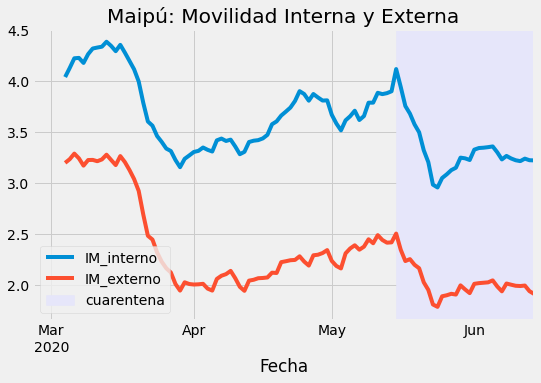

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
codigo_comuna = 13119 #Maipú
comuna = df[df['Codigo comuna'] == codigo_comuna][['Comuna', 'Fecha', 'IM_interno', 'IM_externo', 'IM']]

(comuna.set_index('Fecha')[['IM_interno', 'IM_externo']]
     .rolling(8).mean().plot(ax=ax))
ax.set_title(f"{comuna['Comuna'].iloc[0]}: Movilidad Interna y Externa")

#Fechas de cuarentena:
# Podría haber más de una fila acá si hay más de una cuarentena para esa comuna
cuarentena_com = df_cuarentena[df_cuarentena['Código CUT Comuna'] == 13119]
inicio_cuarentena, fin_cuarentena = cuarentena_com['fecha_inicio'].iloc[0], cuarentena_com['fecha_termino'].iloc[0]
ax.axvspan(pd.to_datetime(inicio_cuarentena), pd.to_datetime(fin_cuarentena), 
           label="cuarentena", color="lavender", alpha=1.)
ax.legend(loc='lower left')

Puesto que los niveles base de cada comuna pueden ser diferentes (la gente de una comuna se mueve más o la relación entre la densidad de antenas y densidad población es diferente), normalizamos el periodo inicial a 1. De esta manera, un 0.7, por ejemplo, significa que la movilidad en ese día está a un 70% de la movilidad del periodo inicial.

La base de datos de movilidad comienza a finales de febrero, por lo que podemos asumir que esas primeras dos semanas representan un periodo relativamente normal para una comuna.

En lo que sigue, vamos a utilizar las series normalizadas de movilidad. Veamos la comparación de las series de tiempo de Las Condes con la Granja y Las Condes con Puente Alto.

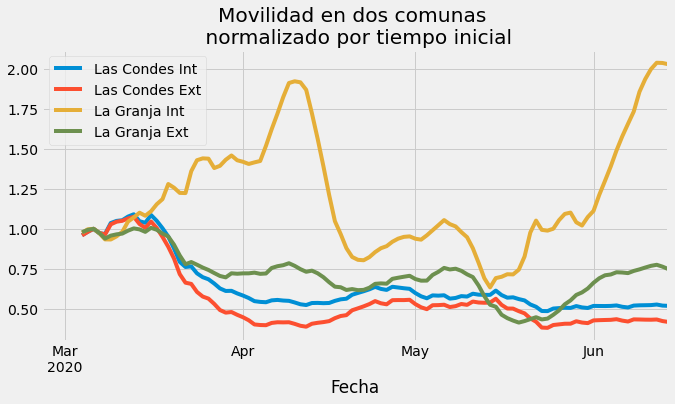

In [8]:
def comparar_dos_comunas(nom_comuna1: str, nom_comuna2: str, df_=df):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    comuna1 = (df_[df_['Comuna'] == nom_comuna1].set_index('Fecha')
     ['IM_interno'].rolling(8).mean())

    (comuna1 / comuna1[9]).plot(ax=ax, label=f"{nom_comuna1} Int")

    comuna1 = (df_[df_['Comuna'] == nom_comuna1].set_index('Fecha')
     ['IM_externo'].rolling(8).mean())
    (comuna1 / comuna1[9]).plot(ax=ax, label=f"{nom_comuna1} Ext")

    comuna2 = (df_[df_['Comuna'] == nom_comuna2].set_index('Fecha')
     ['IM_interno'].rolling(8).mean())
    (comuna2 / comuna2[9]).plot(ax=ax, label=f"{nom_comuna2} Int")

    comuna2 = (df_[df_['Comuna'] == nom_comuna2].set_index('Fecha')
     ['IM_externo'].rolling(8).mean())
    (comuna2 / comuna2[9]).plot(ax=ax, label=f"{nom_comuna2} Ext")
    ax.legend()
    ax.set_title("Movilidad en dos comunas \n normalizado por tiempo inicial");
    
    return fig, ax

comparar_dos_comunas('Las Condes', 'La Granja');

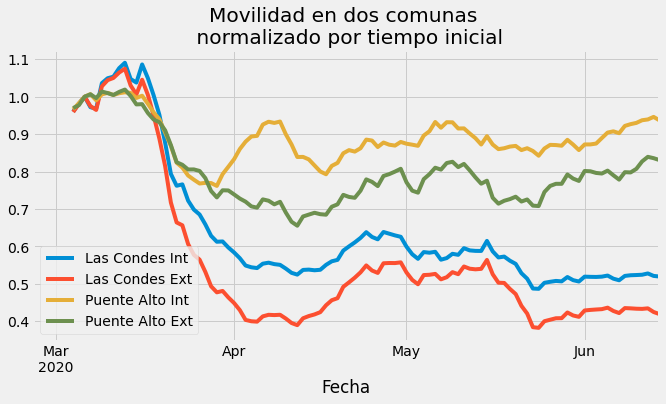

In [9]:
comparar_dos_comunas('Las Condes', 'Puente Alto');

## Efecto de cuarentena

Esperamos que la movilidad de todas las comunas baje con la cuarentena.
Nuestra pregunta es si este cambio depende del porcentaje de pobreza de la comuna.

Nuevamente, vamos a tomar los primeros 10 días como el promedio de movilidad "normal" de una comuna y lo compararemos con la movilidad promedio durante los tiempos de cuarentena

In [27]:
corte_periodo_inicial = df.Fecha.min() + pd.Timedelta("10d")
columnas_comuna = ['Comuna', 'Codigo comuna']
cols_relevantes = ['Porcentaje de personas en situación de pobreza por ingresos 2017',
                  'IM_interno', 'IM_externo']

df_inicial = (df[df.Fecha < corte_periodo_inicial].groupby(columnas_comuna)
                   [cols_relevantes].median()
             .rename(columns={
                 'Porcentaje de personas en situación de pobreza por ingresos 2017':
                             'porc_pobreza',
                  'IM_interno': 'IM_interno_inicial',
             'IM_externo': 'IM_externo_inicial'}))

df_cuarentena = (df[df.cuarentena == 1].groupby(columnas_comuna)
                   ['IM_interno', 'IM_externo'].median()
                .rename(columns={'IM_interno': 'IM_interno_cuarentena',
                  'IM_externo': 'IM_externo_cuarentena'}))


df_delta = pd.merge(df_inicial, df_cuarentena, how='inner',
                    left_index=True, right_index=True).reset_index()

def delta_perc(x_post, x_pre):
    return 2*(x_post - x_pre)/(x_post + x_pre)
for tipo_mov in ['interno', 'externo']:
    #Un número negativo significa que se redujo la movilidad
    df_delta[f'perc_change_IM_{tipo_mov}'] = delta_perc(
                                     df_delta[f'IM_{tipo_mov}_cuarentena'],
                                     df_delta[f'IM_{tipo_mov}_inicial'])


/usr/local/anaconda3/envs/spike_basicoV6/lib/python3.6/site-packages/ipykernel/__main__.py:15: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(-0.03, 0.27)

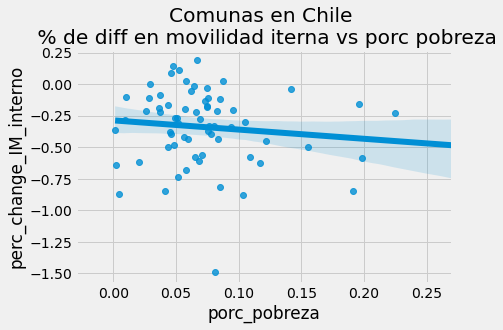

In [11]:
ax = sns.regplot(y="perc_change_IM_interno", x="porc_pobreza",
                     data=df_delta)
ax.set_title("Comunas en Chile \n % de diff en movilidad iterna vs porc pobreza")
ax.set_xlim(-0.03, 0.27)

(-0.03, 0.37)

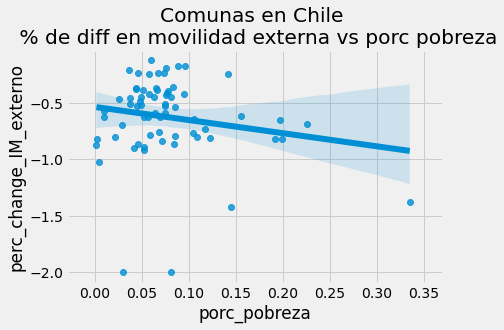

In [12]:
ax = sns.regplot(y="perc_change_IM_externo", x="porc_pobreza",
                     data=df_delta)
ax.set_title("Comunas en Chile \n % de diff en movilidad externa vs porc pobreza")
ax.set_xlim(-0.03, 0.37)

Un número negativo en `perc_change_IM` significa que se **redujo** la movilidad durante la cuarentena. Por ejemplo, un -0.5 significa que se redujo en un 50% la movilidad de la comuna durante la cuarentena (en comparación con los primeros diez días de la muestra)

Para las comunas de todo Chile que han tenido cuarentena (68 de 346), vemos que no hay una relación clara y, si hay algo, es una pequeña correlación negativa: las comunas más pobres tenderían a bajar más la movilidad.

Si consideramos solamente las columnas de la región metropolitana (43 de esas 68), vemos que esta relación se vuelve positiva y más clara. En este caso, a mayor porcentaje de pobreza hay menor cambio en movilidad. 

Un 47% (20 comunas) tiene menos de 20% de reducción de movilidad y un 14% (6 comunas) registra un aumento de movilidad.

In [19]:
codigos_metropolitana = [13123, 13105, 13124, 13111, 13114, 13106, 13103, 13129, 13403,
       13201, 13601, 13101, 13132, 13401, 13119, 13110, 13104, 13113,
       13301, 13404, 13126, 13118, 13130, 13302, 13120, 13131, 13122,
       13502, 13402, 13109, 13116, 13107, 13127, 13102, 13115, 13128,
       13112, 13108, 13501, 13503, 13125, 13203, 13605, 13303, 13604,
       13602, 13117, 13121, 13603, 13505, 13504, 13202]

(-0.03, 0.15)

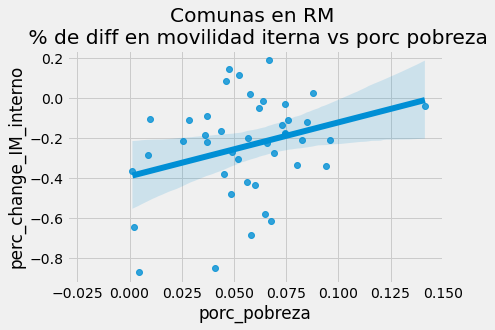

In [20]:
df_delta_metrop = df_delta[df_delta['Codigo comuna'].isin(codigos_metropolitana)]

ax = sns.regplot(y="perc_change_IM_interno", x="porc_pobreza",
                     data=df_delta_metrop, label="holi")
ax.set_title("Comunas en RM \n % de diff en movilidad iterna vs porc pobreza")
ax.set_xlim(-0.03, 0.15)


(-0.03, 0.15)

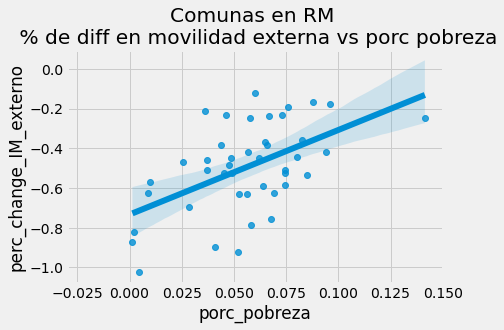

In [21]:

ax = sns.regplot(y="perc_change_IM_externo", x="porc_pobreza",
                     data=df_delta_metrop)
ax.set_title("Comunas en RM \n % de diff en movilidad externa vs porc pobreza")
ax.set_xlim(-0.03, 0.15)

### Una regresión simple

$$ movilidad_t = \alpha_0 + \alpha_1 densidad + \alpha_2 cuarentena + \alpha_3 cuarentena * \%pobreza + \varepsilon $$

¿Qué información nos entrega esta regresión?

+ Controlamos por densidad
+ Nos da un valor "promedio" del efecto de una cuarentena
+ Nos entrega una idea de cómo interactúa la cuarentena con el porcentaje de pobreza de la comuna


In [13]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


df['perc_pobreza'] = df['Porcentaje de personas en situación de pobreza por ingresos 2017']

df = pd.merge(df.reset_index(), df_inicial.reset_index(), on=['Codigo comuna'])

df['IM_interno_norm'] = df['IM_interno'] / df['IM_interno_inicial']
#'IM_interno_norm'?

df_metrop = df.query("Region == 'Metropolitana de Santiago'")

In [16]:

mod = smf.ols(formula='IM_interno_norm ~ density + cuarentena + cuarentena : perc_pobreza',
              data=df_metrop)
res = mod.fit()
results_as_html = res.summary().tables[1].as_html()
resultados_metro = pd.read_html(results_as_html, header=0, index_col=0)[0].T
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:        IM_interno_norm   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     244.0
Date:                Fri, 03 Jul 2020   Prob (F-statistic):          8.36e-149
Time:                        17:57:59   Log-Likelihood:                 343.57
No. Observations:                5610   AIC:                            -679.1
Df Residuals:                    5606   BIC:                            -652.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

Estos resultados indican que un 1% de aumento de pobreza reduciría el efecto de la cuarentena en 2.3%, mientras que un 10% de aumento de pobreza reduce el efecto de la cuarentena en 23.3%. 


Text(0.5, 0, 'Porcentaje de pobreza en la comuna')

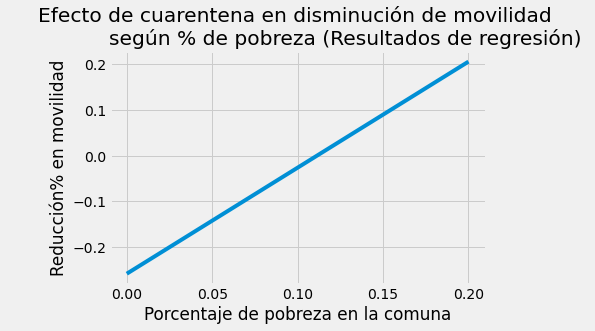

In [18]:
density_median = df_metrop.density.median()
const = -4.314e-06*density_median + 0.9691
beta_cuar = -0.2589
beta_interaccion = 2.3258

fig, ax = plt.subplots(1, 1)
perc_pobreza_array = np.linspace(0., 0.2, 1_000)
ax.plot(perc_pobreza_array, beta_cuar + 2.3258*perc_pobreza_array)
ax.set_title("""Efecto de cuarentena en disminución de movilidad 
                según % de pobreza (Resultados de regresión) """)
ax.set_ylabel("Reducción% en movilidad")
ax.set_xlabel("Porcentaje de pobreza en la comuna")